In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd

data_csv = pd.read_csv('/content/drive/MyDrive/碩一上課堂/1131_dataMining/dataMining/HW4/yelp.csv')
data_csv.columns = data_csv.columns.str.strip()
data_csv.head()

,business_id,date,review_id,stars,text,type,user_id,cool,useful,funny
0,9yKzy9PApeiPPOUJEtnvkg,2011-01-26,fWKvX83p0-ka4JS3dc6E5A,5,My wife took me here on my birthday for breakf...,review,rLtl8ZkDX5vH5nAx9C3q5Q,2,5,0
1,ZRJwVLyzEJq1VAihDhYiow,2011-07-27,IjZ33sJrzXqU-0X6U8NwyA,5,I have no idea why some people give bad review...,review,0a2KyEL0d3Yb1V6aivbIuQ,0,0,0
2,6oRAC4uyJCsJl1X0WZpVSA,2012-06-14,IESLBzqUCLdSzSqm0eCSxQ,4,love the gyro plate. Rice is so good and I als...,review,0hT2KtfLiobPvh6cDC8JQg,0,1,0
3,_1QQZuf4zZOyFCvXc0o6Vg,2010-05-27,G-WvGaISbqqaMHlNnByodA,5,"Rosie, Dakota, and I LOVE Chaparral Dog Park!!...",review,uZetl9T0NcROGOyFfughhg,1,2,0
4,6ozycU1RpktNG2-1BroVtw,2012-01-05,1uJFq2r5QfJG_6ExMRCaGw,5,General Manager Scott Petello is a good egg!!!...,review,vYmM4KTsC8ZfQBg-j5MWkw,0,0,0


# 1. 資料前處理(可延用HW2之方法)：



## a. 讀取資料僅保留"text"、"stars"兩個欄位，利用分割符號切割字串、建立train&test之DataFrame

    並將stars欄位內值大於等於4的轉成1，其餘轉成0

    1: positive

    0: negative

In [ ]:
# 保留 "text" 和 "stars" 欄位
data = data_csv[["text", "stars"]].copy()

# 將 stars 欄位轉換為二元類別
# 大於等於 4 的轉為 1 (positive)，其餘轉為 0 (negative)
data['stars'] = data['stars'].apply(lambda x: 1 if x >= 4 else 0)

# 檢查處理後的資料
data.head()

,text,stars
0,My wife took me here on my birthday for breakf...,1
1,I have no idea why some people give bad review...,1
2,love the gyro plate. Rice is so good and I als...,1
3,"Rosie, Dakota, and I LOVE Chaparral Dog Park!!...",1
4,General Manager Scott Petello is a good egg!!!...,1


## b. 去除停頓詞stop words

In [ ]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# 確保下載所需的資源
nltk.download('stopwords')
nltk.download('punkt')
# Download the 'punkt_tab' resource for sentence tokenization
nltk.download('punkt_tab') # This line is added to download the missing resource.

# 定義停頓詞
stop_words = set(stopwords.words('english'))

# 去除停頓詞的函數
def remove_stop_words(text):
    # 分詞
    words = word_tokenize(text)
    # 過濾掉停頓詞
    filtered_words = [word for word in words if word.lower() not in stop_words]
    # 將過濾後的詞組合回句子
    return ' '.join(filtered_words)

# 移除停頓詞
data['text'] = data['text'].apply(remove_stop_words)

# 檢查處理後的資料
print(data.head())

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


                                                text  stars
0  wife took birthday breakfast excellent . weath...      1
1  idea people give bad reviews place . goes show...      1
2  love gyro plate . Rice good also dig candy sel...      1
3  Rosie , Dakota , LOVE Chaparral Dog Park ! ! !...      1
4  General Manager Scott Petello good egg ! ! ! g...      1


* text 欄位：

  * 這是 Yelp 評論的文字內容，經過了停頓詞移除的處理。
例如，像 "and," "the," "is" 等常見的停頓詞被過濾掉，只保留了對情緒分析可能更重要的詞語，如 "birthday," "excellent," "love," 等。
移除停頓詞的目的是減少噪音並強調評論中具有辨識價值的詞彙，為後續的模型訓練提供更精簡的輸入數據。

## c. 文字轉向量（Ｗord2vec）

In [ ]:
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize
import numpy as np
# 將文字分詞（Tokenize）
data['tokenized_text'] = data['text'].apply(word_tokenize)

# 訓練 Word2Vec 模型
word2vec_model = Word2Vec(sentences=data['tokenized_text'], vector_size=100, window=5, min_count=2, workers=4)

# 為每條評論生成向量（句子的向量為單詞向量的平均值）
def get_sentence_vector(sentence, model):
    vectors = [model.wv[word] for word in sentence if word in model.wv]
    return np.mean(vectors, axis=0) if vectors else np.zeros(model.vector_size)

# 計算每條評論的向量
data['sentence_vector'] = data['tokenized_text'].apply(lambda x: get_sentence_vector(x, word2vec_model))

# 檢查第一條評論的向量
print("第一條評論向量:", data['sentence_vector'].iloc[0])

第一條評論向量: [-0.23142909  0.18114784  0.40228108  0.20316729  0.20384815 -0.77012527
  0.37946156  0.94709563 -0.591953   -0.33477947  0.4033129  -0.5827628
 -0.22614141  0.5094823  -0.22805652 -0.27608323  0.4094824  -0.1767293
 -0.5073678  -0.9991479   0.28068307  0.29460454  0.27577558 -0.2906492
  0.06161363  0.24219026 -0.36570147 -0.06602746 -0.27856526  0.02218161
  0.13358864 -0.21801636  0.33125672 -0.4342233  -0.13249819  0.27362663
  0.32265785 -0.47039747  0.12188303 -0.6444407   0.08814437 -0.18692231
 -0.37749052 -0.23972979  0.26737943 -0.29573485 -0.27375764 -0.10921342
  0.39115292  0.35830247 -0.20145804 -0.34182948  0.00922106  0.19368614
  0.06251612  0.36381036  0.36673808  0.07271903 -0.45469     0.42529246
  0.10067981  0.13953647  0.07745454 -0.07842944 -0.16338736  1.0271324
  0.16358623  0.42554438 -0.43937212  0.48752913 -0.23268634 -0.03274673
  0.18781811 -0.0968941   0.1851928   0.28040525 -0.00339607  0.13209495
 -0.04834838 -0.13298707 -0.3979919   0.160902

* 輸出形狀：

  * 該向量是 Word2Vec 的向量表示，維度由 vector_size 定義（此處為 100 維）。
每個數值代表這條評論在某個向量空間中的語義分佈。
數值解釋：

  * 向量中的每個值反映了評論在特定語義維度上的投影。
正值和負值沒有直觀的語義解釋，但它們的相對值和整體分佈是有用的，特別是當進行分類或回歸等機器學習任務時。

In [ ]:
data

,text,stars,tokenized_text,sentence_vector
0,wife took birthday breakfast excellent . weath...,1,"[wife, took, birthday, breakfast, excellent, ....","[-0.23142909, 0.18114784, 0.40228108, 0.203167..."
1,idea people give bad reviews place . goes show...,1,"[idea, people, give, bad, reviews, place, ., g...","[-0.14577849, 0.036988724, 0.24384479, 0.33297..."
2,love gyro plate . Rice good also dig candy sel...,1,"[love, gyro, plate, ., Rice, good, also, dig, ...","[-0.21582472, 0.4143621, 0.27463105, 0.1084079..."
3,"Rosie , Dakota , LOVE Chaparral Dog Park ! ! !...",1,"[Rosie, ,, Dakota, ,, LOVE, Chaparral, Dog, Pa...","[-0.0936799, 0.05060749, 0.039755546, 0.220056..."
4,General Manager Scott Petello good egg ! ! ! g...,1,"[General, Manager, Scott, Petello, good, egg, ...","[-0.23984121, 0.05407579, -0.044937532, -0.005..."
...,...,...,...,...
9995,First visit ... lunch today - used Groupon . o...,0,"[First, visit, ..., lunch, today, -, used, Gro...","[-0.1824445, 0.236286, 0.32286814, 0.19796889,..."
9996,"called house deliciousness ! could go item , i...",1,"[called, house, deliciousness, !, could, go, i...","[-0.043673962, 0.016979076, 0.2815596, 0.20090..."
9997,recently visited Olive Ivy business last week ...,1,"[recently, visited, Olive, Ivy, business, last...","[-0.17075238, 0.069469444, 0.20196898, 0.22462..."
9998,nephew moved Scottsdale recently bunch friends...,0,"[nephew, moved, Scottsdale, recently, bunch, f...","[-0.14085771, -0.03388557, 0.026640192, 0.1187..."


# 資料分割

#  建模（CNN）

In [ ]:
X_train_cnn = np.expand_dims(X_train, axis=-1)  # 增加最後一維
X_test_cnn = np.expand_dims(X_test, axis=-1)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Flatten, Dropout, Dense

# 修正的 CNN 模型
cnn_model = Sequential([
    Input(shape=(X_train_cnn.shape[1], 1)),  # 指定輸入形狀
    Conv1D(64, 3, activation='relu'),  # 第一層卷積
    MaxPooling1D(2),  # 使用最大池化層
    Conv1D(128, 3, activation='relu'),  # 第二層卷積
    MaxPooling1D(2),  # 再次最大池化
    Flatten(),  # 扁平化輸出
    Dropout(0.5),  # Dropout 防止過擬合
    Dense(128, activation='relu'),  # 全連接層
    Dropout(0.5),
    Dense(2, activation='softmax')  # 輸出層
])


# 編譯模型
cnn_model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

# 顯示模型摘要
cnn_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_2 (Conv1D)                    │ (None, 498, 64)             │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_2 (MaxPooling1D)       │ (None, 249, 64)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_3 (Conv1D)                    │ (None, 247, 128)            │          24,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_3 (MaxPooling1D)       │ (None, 123, 128)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 15744)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 15744)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │       2,015,360 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,040,578 (7.78 MB)

 Trainable params: 2,040,578 (7.78 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# 計算類別權重
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(data['stars']),
    y=data['stars']
)
class_weight_dict = dict(enumerate(class_weights))
print("Class weights:", class_weight_dict)

# 調整輸入維度
X_train_cnn = np.expand_dims(X_train, axis=-1)
X_test_cnn = np.expand_dims(X_test, axis=-1)

# 訓練模型
history = cnn_model.fit(
    X_train_cnn,
    y_train,
    validation_split=0.2,
    epochs=10,
    batch_size=64,
    class_weight=class_weight_dict  # 加入類別權重
)


Class weights: {0: 1.593879502709595, 1: 0.7285443683520326}
Epoch 1/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - accuracy: 0.6541 - loss: 0.6507 - val_accuracy: 0.7050 - val_loss: 0.5597
Epoch 2/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7330 - loss: 0.5265 - val_accuracy: 0.7419 - val_loss: 0.5241
Epoch 3/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7783 - loss: 0.4865 - val_accuracy: 0.7606 - val_loss: 0.5018
Epoch 4/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7743 - loss: 0.4700 - val_accuracy: 0.7594 - val_loss: 0.5095
Epoch 5/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7978 - loss: 0.4461 - val_accuracy: 0.7431 - val_loss: 0.5318
Epoch 6/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8099 - loss: 0.4179 - val_accuracy: 0.7425 - val_loss: 0.5352
Epoch 7/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8227 - loss: 0.3903 - val_accuracy: 0.7675 - val_loss: 0.5096
Epoch 8/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s

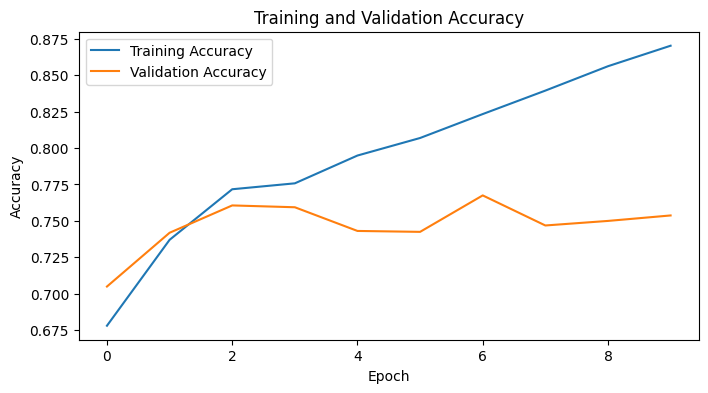

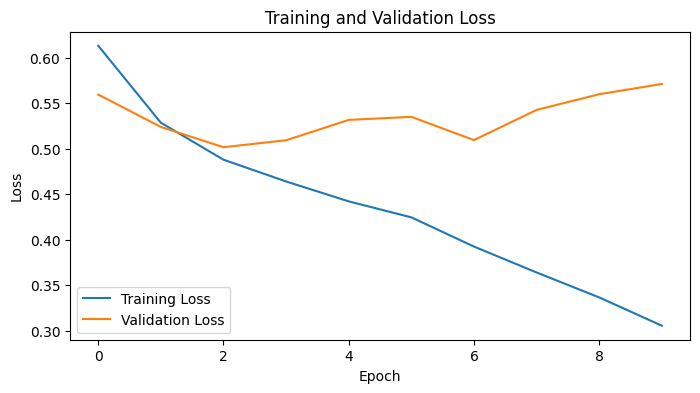

In [ ]:
import matplotlib.pyplot as plt

# 繪製 Accuracy
plt.figure(figsize=(8, 4))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# 繪製 Loss
plt.figure(figsize=(8, 4))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# 使用測試資料進行評估
test_loss, test_accuracy = cnn_model.evaluate(X_test_cnn, y_test)
print(f"Test Accuracy: {test_accuracy:.4f}")

63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.7844 - loss: 0.5487
Test Accuracy: 0.7765


63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step


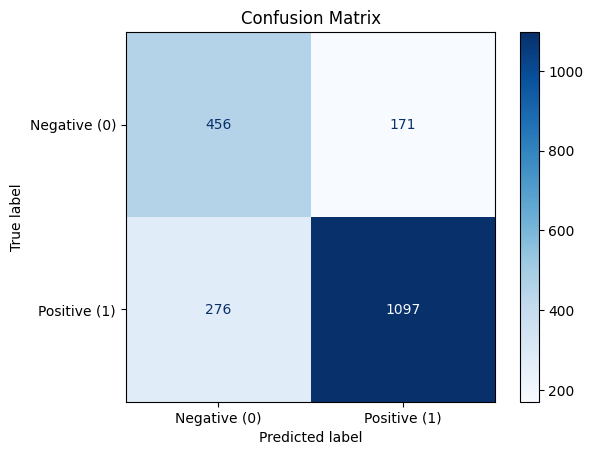

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# 預測測試集的類別（使用模型）
y_pred = cnn_model.predict(X_test_cnn)
y_pred_classes = np.argmax(y_pred, axis=1)  # 取最大值的索引作為預測類別
y_test_classes = np.argmax(y_test, axis=1)  # 取真實類別的索引

# 計算混淆矩陣
cm = confusion_matrix(y_test_classes, y_pred_classes)

# 繪製混淆矩陣
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Negative (0)', 'Positive (1)'])
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix')
plt.show()


# LSTM 1118

In [ ]:
X_test.shape

(2000, 100)

In [ ]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Bidirectional, Dense, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Step 1: 數據準備
# 假設 sentence_vector 已經是嵌入向量，stars 是目標變數
X = np.array(data['sentence_vector'].tolist())  # 將 sentence_vector 轉換為 numpy 數組
y = np.array(data['stars'])  # 目標值

print("X shape:", X.shape)  # 應為 (10000, vector_length)
print("y shape:", y.shape)  # 應為 (10000,)

# 標準化數據
scaler = StandardScaler()
X = scaler.fit_transform(X)  # 對數據進行標準化

# 轉換目標值為 One-hot 編碼
y_one_hot = to_categorical(y, num_classes=2)

# 將數據分為訓練集和測試集
X_train, X_test, y_train, y_test = train_test_split(X, y_one_hot, test_size=0.2, random_state=42)
print("X_train shape:", X_train.shape)  # (8000, vector_length)
print("X_test shape:", X_test.shape)   # (2000, vector_length)

# 確保數據形狀正確
vector_length = X_train.shape[1]
X_train = X_train.reshape(-1, vector_length, 1)  # LSTM 需要 3D 輸入
X_test = X_test.reshape(-1, vector_length, 1)

# Step 2: 設計 LSTM 模型
lstm_model = Sequential([
    Input(shape=(vector_length, 1)),
    Bidirectional(LSTM(256, return_sequences=True, activation='tanh')),  # 第一層 LSTM
    BatchNormalization(),
    Dropout(0.5),
    Bidirectional(LSTM(128, return_sequences=True, activation='tanh')),  # 第二層 LSTM
    BatchNormalization(),
    Dropout(0.5),
    LSTM(64, activation='tanh'),  # 第三層 LSTM
    BatchNormalization(),
    Dense(128, activation='relu'),  # 全連接層
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dense(2, activation='softmax')  # 輸出層
])

# 顯示模型摘要
lstm_model.summary()

# Step 3: 編譯模型
lstm_model.compile(optimizer='adam',
                   loss='binary_crossentropy',
                   metrics=['accuracy'])

# Step 4: 訓練模型
history = lstm_model.fit(
    X_train,  # 已經轉換為 3D 的輸入
    y_train,
    validation_split=0.2,
    epochs=20,  # 減少 Epoch 到 50，根據需求調整
    batch_size=64
)

# Step 5: 評估模型性能
loss, accuracy = lstm_model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}, Test Accuracy: {accuracy}")


X shape: (10000, 100)
y shape: (10000,)
X_train shape: (8000, 100)
X_test shape: (2000, 100)


Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ bidirectional_18 (Bidirectional)     │ (None, 100, 512)            │         528,384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_11               │ (None, 100, 512)            │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_20 (Dropout)                 │ (None, 100, 512)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_19 (Bidirectional)     │ (None, 100, 256)            │         656,384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_12               │ (None, 100, 256)            │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_21 (Dropout)                 │ (None, 100, 256)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_42 (LSTM)                       │ (None, 64)                  │          82,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_13               │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_40 (Dense)                     │ (None, 128)                 │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_22 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_41 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_42 (Dense)                     │ (None, 2)                   │             130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,286,978 (4.91 MB)

 Trainable params: 1,285,314 (4.90 MB)

 Non-trainable params: 1,664 (6.50 KB)

Epoch 1/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 11s 54ms/step - accuracy: 0.6550 - loss: 0.6396 - val_accuracy: 0.6975 - val_loss: 0.6194
Epoch 2/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.7178 - loss: 0.5760 - val_accuracy: 0.6981 - val_loss: 0.5840
Epoch 3/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.7111 - loss: 0.5709 - val_accuracy: 0.7038 - val_loss: 0.5852
Epoch 4/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - accuracy: 0.6979 - loss: 0.5932 - val_accuracy: 0.7081 - val_loss: 0.5562
Epoch 5/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - accuracy: 0.7225 - loss: 0.5597 - val_accuracy: 0.7225 - val_loss: 0.5621
Epoch 6/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - accuracy: 0.7238 - loss: 0.5565 - val_accuracy: 0.7300 - val_loss: 0.5490
Epoch 7/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - accuracy: 0.7356 - loss: 0.5372 - val_accuracy: 0.7206 - val_loss: 0.5554
Epoch 8/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - accuracy: 0.7133 - loss: 0.5591 - val_acc

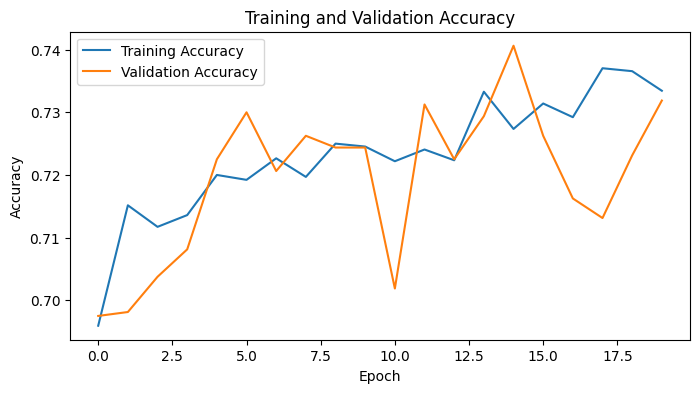

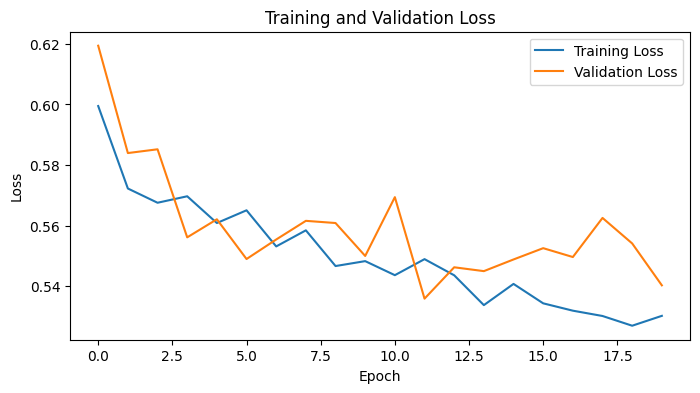

In [ ]:
import matplotlib.pyplot as plt

# 繪製 Accuracy
plt.figure(figsize=(8, 4))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# 繪製 Loss
plt.figure(figsize=(8, 4))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step


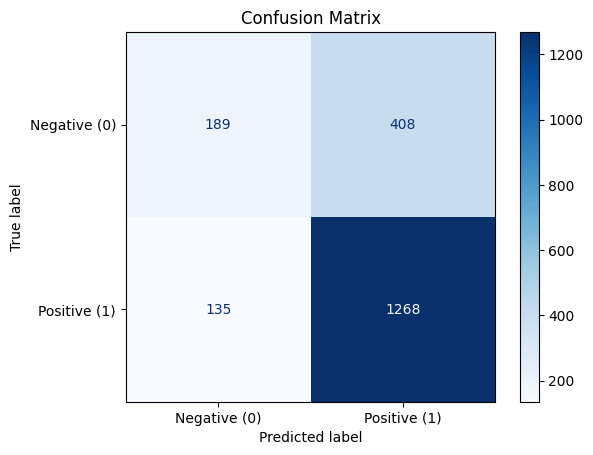

In [ ]:

# 預測測試集的類別（使用模型）
y_pred = lstm_model.predict(X_test)  # 設置批量大小提高效率
y_pred_classes = np.argmax(y_pred, axis=1)  # 取最大值的索引作為預測類別
y_test_classes = np.argmax(y_test, axis=1)  # 取真實類別的索引

# 計算混淆矩陣
cm = confusion_matrix(y_test_classes, y_pred_classes)

# 繪製混淆矩陣
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Negative (0)', 'Positive (1)'])
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix')
plt.show()